In [1]:
# %reset
import numpy as np
import pickle as pk

from astropy import units as u
from astropy import constants as const
from astropy.io import fits

import sys, os

Color = ['k', '#000075', '#a9a9a9','#9A6324', '#808000','#aaffc3', '#fffac8'  ,'#800000', '#ffd8b1',]

import matplotlib
import matplotlib.pyplot as pl
font = {'size'   : 18}
matplotlib.rc('font', **font)
pl.rc('text', usetex=False)
pl.rc('font', family='serif')

%matplotlib inline




In [2]:
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck18')
from colossus.halo import mass_so
mdef = '200c'
# mdef = '200c'
# mdef = '500c'
import astropy.units as units
import astropy.constants as const




In [3]:
import scipy as sp
#Eq. 8
def m(x):
    return np.log(1 + x) - x/(1+x)

# Eq. 9
def int_mu_un2(x):
    return 1 - (np.log(1+x))/x

# Eq. 21
def s_star_func(xstar):
    return -1*(1 + 2*xstar/(1+xstar))

# Eq. 23
def eta0_func(xstar, c, gamma):
    s_star = s_star_func(xstar)
    m_xstar = m(xstar)
    mc = m(c)
    int_mu_un2_xstar = int_mu_un2(xstar)
    val = (1/gamma)*((-3/s_star)*(c*m_xstar/(xstar*mc)) + 3*(gamma-1)*(c/mc)*int_mu_un2_xstar)
    return val

# Fig.2
def get_gamma(c):
    xstar_vals = np.linspace(c/2, 2*c, 6)
    gamma_vals = np.linspace(1.0, 1.7, 80)
    eta0_all = np.zeros((len(xstar_vals), len(gamma_vals)))
    for jx in range(len(xstar_vals)):
        for jg in range(len(gamma_vals)):
            eta0_all[jx,jg] = eta0_func(xstar_vals[jx], c, gamma_vals[jg])
    
    deta0_dxstar_all = np.zeros(len(gamma_vals))
    for jg in range(len(gamma_vals)):
        deta0_dxstar_all[jg] = np.mean(np.gradient(eta0_all[:,jg], xstar_vals))
    indmin = np.argmin(np.abs(deta0_dxstar_all))
    return gamma_vals[indmin]

# Eq. 19
def ygas(x, gamma, c):
    eta0 = eta0_func(c, c, gamma)
    int_mu_un2_x = int_mu_un2(x)
    mc = m(c)
    val = 1 - (3/eta0)*((gamma - 1)/gamma)*(c/mc)*int_mu_un2_x        
    return val**(1/(gamma-1))

# Eq. 20 (coeff here is supplied when calculating the final pressure profile)
def Tgas(x, gamma, c, Mvir):
    ygasx = ygas(x, gamma, c)
    return (ygasx**(gamma-1.))

# Eq. 15 (coeff here is free and setting it to 1.)
def rhogas(x, gamma, c, coeff=1.):
    ygasx = ygas(x, gamma, c)
    return coeff*ygasx


def coeffgas_full(gamma, c, Mvir=1e15, fb_cosmo=0.048/0.3):
    r = np.linspace(0.01, 5, 2000)
    rvir = mass_so.M_to_R(Mvir, 0.0, mdef)/1000.
    rs = rvir/c
    x = r/rs
    ygasx = ygas(x, gamma, c)
    indsel = np.where(r < rvir)[0]
    ygasx_int = sp.integrate.simps((ygasx*4*np.pi*r**2)[indsel], r[indsel])
    coeff = (Mvir/ygasx_int)*fb_cosmo
    return coeff


def rhogas_r(r, gamma, c, Mvir=1e15, fb_cosmo=0.048/0.3):
    rvir = mass_so.M_to_R(Mvir, 0.0, mdef)/1000.
    rs = rvir/c
    x = r/rs
    ygasx = ygas(x, gamma, c)
    coeff = coeffgas_full(gamma, c, Mvir=Mvir, fb_cosmo=fb_cosmo)
    return coeff*ygasx


def P0gas(x, gamma, c, Mvir, coeff_rho=1., coeff_T=1.):
    kB_Tgas = Tgas(x, gamma, c, Mvir)
    rho_gas = rhogas(x, gamma, c, coeff=coeff_rho)
    P_gas = rho_gas*(kB_Tgas)
    return P_gas
    
def P0gas_r(r, gamma, c, Mvir, rmax_rvir=5.0):
    rvir = mass_so.M_to_R(Mvir, 0.0, mdef)/1000.
    rs = rvir/c
    x = r/rs
    mu=0.59
    eta0 = eta0_func(c, c, gamma)
    kB_T0 = (1./3.)*eta0*((Mvir*units.Msun/(rvir*units.Mpc))*mu*(const.G*const.m_p)).to(units.keV)
    kB_Tgas = kB_T0*Tgas(x, gamma, c, Mvir)
    rho_gas = rhogas_r(r, gamma, c, Mvir=Mvir, fb_cosmo=cosmo.Ob0/cosmo.Om0)
    P_gas = 55*rho_gas*((cosmo.h**2)/(1e14))*(kB_Tgas/8.)    
    indsel = np.where(r>rmax_rvir*rvir)[0]
    P_gas[indsel] = 0.0
    return P_gas

def P0gas_2Dr(rp_array, gamma, c, Mvir, rmax_rvir=5.0):
    Px_2D = np.zeros_like(rp_array)
    for jr in range(len(rp_array)):
        r = np.linspace(1.03*rp_array[jr], 5.0, 500)
        rvir = mass_so.M_to_R(Mvir, 0.0, mdef)/1000.
        rs = rvir/c
        x = r/rs
        mu=0.59
        eta0 = eta0_func(c, c, gamma)
        kB_T0 = (1./3.)*eta0*((Mvir*units.Msun/(rvir*units.Mpc))*mu*(const.G*const.m_p)).to(units.keV)
        kB_Tgas = kB_T0*Tgas(x, gamma, c, Mvir)
        rho_gas = rhogas_r(r, gamma, c, Mvir=Mvir, fb_cosmo=cosmo.Ob0/cosmo.Om0)
        Px_3D = 55*rho_gas*((cosmo.h**2)/(1e14))*(kB_Tgas/8.)   
        indsel = np.where(r>rmax_rvir*rvir)[0]
        Px_3D[indsel] = 0.0
        Px_2D[jr] = 2*sp.integrate.simps(r*Px_3D/(np.sqrt(r**2 - (rp_array[jr])**2)),r)
    return Px_2D


def get_cSZ(rp_array, gamma, c, Mvir, rmax_rvir=2.0):
    Px_2D = np.zeros_like(rp_array)
    for jr in range(len(rp_array)):
        r = np.linspace(1.01*rp_array[jr], 5.0, 500)
        rvir = mass_so.M_to_R(Mvir, 0.0, mdef)/1000.
        rs = rvir/c
        x = r/rs
        mu=0.59
        eta0 = eta0_func(c, c, gamma)
        kB_T0 = (1./3.)*eta0*((Mvir*units.Msun/(rvir*units.Mpc))*mu*(const.G*const.m_p)).to(units.keV)
        kB_Tgas = kB_T0*Tgas(x, gamma, c, Mvir)
        rho_gas = rhogas_r(r, gamma, c, Mvir=Mvir, fb_cosmo=cosmo.Ob0/cosmo.Om0)
        Px_3D = 55*rho_gas*((cosmo.h**2)/(1e14))*(kB_Tgas/8.)          
        indsel = np.where(r>rmax_rvir*rvir)[0]
        Px_3D[indsel] = 0.0        
        Px_2D[jr] = 2*sp.integrate.simps(r*Px_3D/(np.sqrt(r**2 - (rp_array[jr])**2)),r)
        
    dlog_rp = np.log(rp_array)[1] - np.log(rp_array)[0]
    dlogPc1_dlogrp = np.gradient(np.log(Px_2D), dlog_rp)        
    indsel = np.where(dlogPc1_dlogrp < -1)[0][0]
    rp_val_n1 = rp_array[indsel]
    r200m = mass_so.M_to_R(Mvir, 0.0, mdef)/1000.
    c_SZ = r200m/rp_val_n1
        
    return c_SZ




In [4]:
def rhoDM(x, c, Mvir):
    mc = m(c)
    rvir = mass_so.M_to_R(Mvir, 0.0, mdef)/1000.
    rhos = (c**3)*(Mvir/(4*np.pi*(rvir**3)*mc))
    ydm = rhos*(1/(x*((1+x)**2)))
    # if x>c:
    try:
        ydm[x>c] = 0.0
    except:
        if x>c:
            ydm = 0.0
    return ydm


    
def ydm_r(r, c, Mvir):
    rvir = mass_so.M_to_R(Mvir, 0.0, mdef)/1000.
    rs = rvir/c
    x = r/rs
    return rhoDM(x, c, Mvir)


def rhoDM_2Dr(rp_array, c, Mvir):
    Px_2D = np.zeros_like(rp_array)
    for jr in range(len(rp_array)):
        r = np.linspace(1.01*rp_array[jr], 5.0, 100)
        rvir = mass_so.M_to_R(Mvir, 0.0, mdef)/1000.
        rs = rvir/c
        x = r/rs
        Px_3D = rhoDM(x, c, Mvir)        
        Px_2D[jr] = 2*sp.integrate.simps(r*Px_3D/(np.sqrt(r**2 - (rp_array[jr])**2)),r)
    # print(Px_2D)
    return Px_2D




In [5]:
from tqdm import tqdm
from colossus.halo import mass_defs
from colossus.halo import mass_so

c_dm_vals = np.linspace(1.5,10.0,10)

M200c_array = np.logspace(np.log10(1e13), np.log10(1e16), 10)

Y200csz_vals = np.zeros((len(M200c_array), len(c_dm_vals)))
r200c_mat = np.zeros((len(M200c_array), len(c_dm_vals)))
nrp = 300
Pgas_2D_all = np.zeros((len(M200c_array), len(c_dm_vals), nrp))
Pgas_3D_all = np.zeros((len(M200c_array), len(c_dm_vals), nrp))
gamma_all = np.zeros(len(c_dm_vals))
for jM in tqdm(range(len(M200c_array))):
    M200c = M200c_array[jM]

    for jc in range(len(c_dm_vals)):
        r200c = mass_so.M_to_R(M200c, 0.0, '200c')/1000.
        rp_array = np.linspace(0.01, 5.0, nrp)
        gammav = get_gamma(c_dm_vals[jc])
        r200c_mat[jM, jc] = r200c
        Pgas_2D = P0gas_2Dr(rp_array, gammav, c_dm_vals[jc], M200c)
        Pgas_3D = P0gas_r(rp_array, gammav, c_dm_vals[jc], M200c)
        Pgas_2D_all[jM, jc,:] = Pgas_2D
        Pgas_3D_all[jM, jc,:] = Pgas_3D
        indsel = np.where(rp_array > r200c)[0]
        Pgas_2D_cut = np.copy(Pgas_2D)
        Pgas_2D_cut[indsel] = 0.0
        Y200csz_vals[jM, jc] = sp.integrate.simps(Pgas_2D_cut*2*np.pi*rp_array, rp_array)
        gamma_all[jc] = gammav


    

  0%|          | 0/10 [00:00<?, ?it/s]/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
 50%|█████     | 5/10 [00:20<00:20,  4.13s/it]/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
100%|██████████| 10/10 [00:41<00:00,  4.16s/it]


Text(0, 0.5, '$P_e(r_p)$')

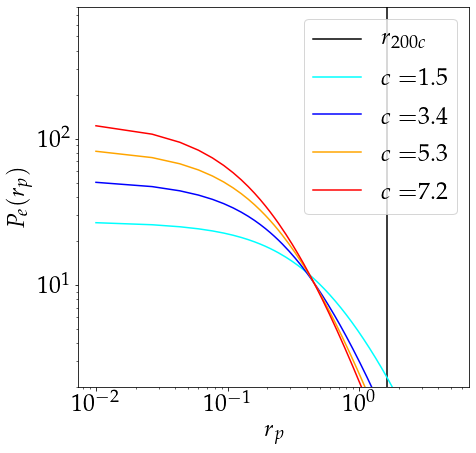

In [14]:
jM = 6
pl.figure()
r200c = mass_so.M_to_R(M200c_array[jM], 0.0, '200c')/1000.
pl.axvline(r200c, ls='-', color='k', label=r'$r_{200c}$')

pl.plot(rp_array, Pgas_2D_all[jM, 0,:], color='cyan', label=r'$c=$' + str(np.round(c_dm_vals[0],1)))
# pl.axvline(r200c_mat[jM, 0], ls='--', color='cyan')
pl.plot(rp_array, Pgas_2D_all[jM, 2,:], color='blue', label=r'$c=$' + str(np.round(c_dm_vals[2],1)))
# pl.axvline(r200c_mat[jM, 2], ls='--', color='blue')
pl.plot(rp_array, Pgas_2D_all[jM, 4,:], color='orange', label=r'$c=$' + str(np.round(c_dm_vals[4],1)))
# pl.axvline(r200c_mat[jM, 4], ls='--', color='orange')
pl.plot(rp_array, Pgas_2D_all[jM, 6,:], color='red', label=r'$c=$' + str(np.round(c_dm_vals[6],1)))
# pl.axvline(r200c_mat[jM, 6], ls='--', color='red')
pl.legend()
pl.xscale('log')
pl.yscale('log')
pl.ylim(2.0, 800)
pl.xlabel(r'$r_p$')
pl.ylabel(r'$P_e(r_p)$')





In [11]:
# np.log10(M200c_array[jM])
M200m, R200m, c200m = mass_defs.changeMassDefinition(M200c_array[jM], c_dm_vals[jc], 0.0, '200c', '200m')
print(M200m)




15.666666666666666

Text(0, 0.5, '$Y_{200c}/M^{5/3}_{200c}$')

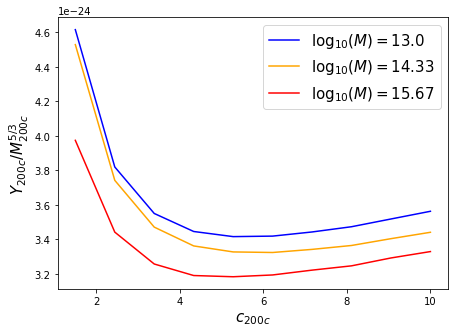

In [14]:
pl.figure(figsize=(7,5))
# ind = 5
pl.plot(c_dm_vals, Y200csz_vals[0,:]/(M200c_array[0]**(5/3)), color='blue', label=r'$\log_{10}(M)=$' + str(np.round(np.log10(M200c_array[0]),2)))
pl.plot(c_dm_vals, Y200csz_vals[4,:]/(M200c_array[4]**(5/3)),color='orange', label=r'$\log_{10}(M)=$' + str(np.round(np.log10(M200c_array[4]),2)))
pl.plot(c_dm_vals, Y200csz_vals[8,:]/(M200c_array[8]**(5/3)),color='red', label=r'$\log_{10}(M)=$' + str(np.round(np.log10(M200c_array[8]),2)))
pl.legend(fontsize=15)
pl.xlabel(r'$c_{200c}$', size=15)
pl.ylabel(r'$Y_{200c}/M^{5/3}_{200c}$', size=15)




In [21]:
from tqdm import tqdm
from colossus.halo import mass_defs
# rp_array = np.logspace(np.log10(0.01), np.log10(2.0), 1000)
c200m_dm_vals = np.linspace(1.5,10.0,10)

# M200m_array = np.logspace(np.log10(1e14), np.log10(2e15), 10)
M200m_array = np.logspace(np.log10(1e13), np.log10(1e16), 10)

Y200sz_vals = np.zeros((len(M200m_array), len(c200m_dm_vals)))
# M500c_mat = np.zeros_like(Y500sz_vals)
for jM in tqdm(range(len(M200m_array))):
    M200m = M200m_array[jM]

    # r500c = mass_so.M_to_R(Mvir, 0.0, '500c')/1000.
    for jc in range(len(c200m_dm_vals)):
        # M500c = 
        M200c, R200c, _ = mass_defs.changeMassDefinition(M200m, c200m_dm_vals[jc], 0.0, '200m', '200c')
        r200c = R200c/1000.
        # M500c_mat[jM, jc] = M500c
        rp_array = np.linspace(0.01, 5.0, 500)
        gammav = get_gamma(c200m_dm_vals[jc])
        Pgas_2D = P0gas_2Dr(rp_array, 1.15, c200m_dm_vals[jc], M200m)
        indsel = np.where(rp_array > r200c)[0]
        Pgas_2D_cut = np.copy(Pgas_2D)
        Pgas_2D_cut[indsel] = 0.0
        Y200sz_vals[jM, jc] = sp.integrate.simps(Pgas_2D_cut*2*np.pi*rp_array, rp_array)
        
        
    
    

100%|██████████| 20/20 [03:28<00:00, 10.42s/it]


Text(0, 0.5, '$Y_{200c}$')

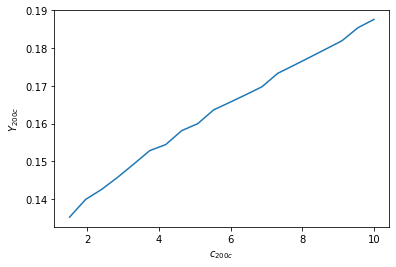

In [22]:
pl.figure()
ind = 5
pl.plot(c_dm_vals, Y200sz_vals[ind,:])
# pl.plot(c_dm_vals, Y500sz_vals_smooth[ind,:])
# z = np.polyfit(c_dm_vals, Y500sz_vals[ind,:], 3)
# p = np.poly1d(z)
# pl.plot(c_dm_vals, p(c_dm_vals))
# pl.plot(M200m_array, (1/1e24)*(M200m_array)**(5/3))
# pl.yscale('log')
# pl.xscale('log')
# pl.ylim(1e-3,1e3)
pl.xlabel(r'$c_{200m}$')
pl.ylabel(r'$Y_{200c}$')




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


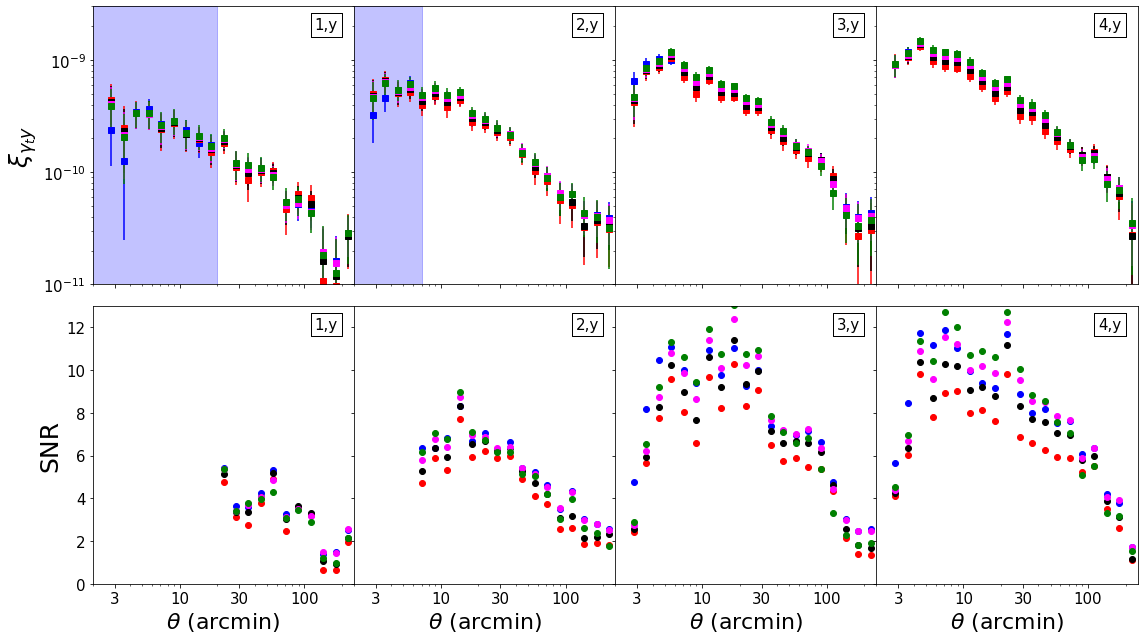

In [7]:
import scipy.interpolate as interpolate
def QR_inverse(matrix):
    _Q,_R = np.linalg.qr(matrix)
    return np.dot(_Q,np.linalg.inv(_R.T))
from astropy.io import fits
import pickle as pk
import numpy as np
import dill
import matplotlib
%matplotlib inline

# # df = fits.open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/actxdes_shear/DES_planck_ACT_theorycov.fits')

# df = fits.open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/actxdes_shear/DES_planck_ACT_theorycov.fits')   


# # desy1 = fits.open('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/data/v0.40_fiducial.fits')

nbins = 4
bins1 = np.array([1,2,3,4])
# bins2 = np.array([4,4,4,4])
bins2 = np.array([1,2,3,4])

# bins2 = np.array([2,2,2,2])
fig, ax = pl.subplots(2,4, figsize = (16,9),sharex=True,sharey='row', gridspec_kw = {'wspace':0})   
jc = 0
# texts_kk = [r'1,1',r'2,2',r'3,3',r'4,4']
texts_kk = []
for j1 in range(len(bins1)):
    texts_kk.append(str(bins1[j1]) + ',' + str(bins2[j1]))
texts_ky = [r'1,y',r'2,y',r'3,y',r'4,y']
sc1 = [20,7.1,1.1,1.1]
sc = [20,10.,7.1,7.1]
ldir = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/run_measurements/results_ACT_DR6_DES_Y3_18Oct22_newmask/'
deproj_all = ['None','cib_1p0', 'cib','cib_1p4','cib_1p6']
colors = ['b','r','k','magenta','green','orange']
for j1 in range(len(deproj_all)):    
    
    for j2 in range(4):
        df = dill.load(open(ldir + 'kg_act_deprojects_' + deproj_all[j1] + '_vnew_wbeam_pixell_zbin_' + str(j2) + '_njk_250_healpix4096_theta_2p5_250_v21May22.pk','rb'))
                
#         bin1y = df['compton_shear'].data['BIN1']
#         bin2y = df['compton_shear'].data['BIN2']
#         ind_sely = np.where((bin1y == bins1[j2]) & (bin2y == bins2[j2]))[0]

#         bin1y = df['compton1_shear'].data['BIN1']
#         bin2y = df['compton1_shear'].data['BIN2']
#         ind_sely1 = np.where((bin1y == bins1[j2]) & (bin2y == bins2[j2]))[0]

        rkg = df['r_kg']
        covkg = df['cov_dy']
        xikg = df['xi_kg']
        sigkg = np.sqrt(np.diag(covkg))
#         yk_th_g = df['compton_shear'].data['ANG'][ind_sely]
#         yk_val = df['compton_shear'].data['VALUE'][ind_sely]
#         yk_err = np.sqrt(np.diag(df['COVMAT'].data[400:480,400:480][ind_sely,:][:,ind_sely]))            

#         yk_th_g1 = df['compton1_shear'].data['ANG'][ind_sely1]
#         yk_val1 = df['compton1_shear'].data['VALUE'][ind_sely1]
#         yk_err1 = np.sqrt(np.diag(df['COVMAT'].data[480:,480:][ind_sely1,:][:,ind_sely1]))            
        if j1 == 0:
            ax[0,j2].errorbar(rkg,xikg, sigkg, ls='',marker='s',color=colors[j1])
        else:
            ax[0,j2].errorbar(rkg,xikg, sigkg, ls='',marker='s',color=colors[j1])
        # ax[0,j2].errorbar(1.07*yk_th_g1, yk_val1,yk_err1, ls='',marker='o',color='red',label=r'ACT $\times$ DES')
        # ax[0,j2].axvspan(0,sc[j2],alpha=0.15,color='b')
        ax[0,j2].axvspan(0,sc1[j2],alpha=0.05,color='b')
        
        # ind_sel = np.where(yk_th_g > sc[j2])[0]
        # ax[1,j2].errorbar(rkg[ind_sel],(xikg/sigkg)[ind_sel], ls='',marker='s',color='blue',label=r'Planck $\times$ DES')
        ind_sel = np.where(rkg > sc1[j2])[0]
        ax[1,j2].errorbar(rkg[ind_sel],(xikg/sigkg)[ind_sel], ls='',marker='o',color=colors[j1])  
        
        
        ax[0,j2].set_xscale('log')
        ax[0,j2].set_yscale('log')
        
        ax[1,j2].set_xlabel(r'$\theta$ (arcmin)', size = 22)
        ticks  = np.array([3,10,30,100])
        labels_bottom = ticks
        ax[1,j2].set_xticks(ticks)
        ax[0,j2].set_xticks(ticks)
        ax[1,j2].set_xticklabels(labels_bottom,  fontsize=15)
            
        ax[0,j2].tick_params(axis='both', which='minor', labelsize=15)    
        ax[0,j2].tick_params(axis='both', which='major', labelsize=15)
        ax[1,j2].tick_params(axis='both', which='minor', labelsize=15)    
        ax[1,j2].tick_params(axis='both', which='major', labelsize=15)
        
        ax[0,j2].set_xlim((2,250))
        ax[0,j2].set_ylim((1e-11,3e-9))
        ax[1,j2].set_ylim((0,13))
        
        ax[0,j2].text( 0.85, 0.96,texts_ky[j2], verticalalignment='top', horizontalalignment='left', transform=ax[0,j2].transAxes, fontsize=15, bbox=dict(facecolor='white', edgecolor='black'))    
        ax[1,j2].text( 0.85, 0.96,texts_ky[j2], verticalalignment='top', horizontalalignment='left', transform=ax[1,j2].transAxes, fontsize=15, bbox=dict(facecolor='white', edgecolor='black'))    


        jc += 1



# ax[0,0].set_ylabel(r'$\xi_{\rm mm}$ comparison', size = 22)
ax[0,0].set_ylabel(r'$\xi_{\gamma_t y}$ ', size = 25)
ax[1,0].set_ylabel(r'SNR', size = 25)
# ax[1,0].set_ylabel(r'$\xi_{y\kappa}(\theta)$ ', size = 22)
# ax[1,0].set_ylabel(r'$\sigma(\xi_{+},\xi_{+})$ ', size = 22)
# ax[2,0].set_ylabel(r'$\sigma(\xi_{-},\xi_{-})$ ', size = 22)
ax[1,0].legend(fontsize=15,loc='upper left',frameon=False)
# ax[0,0].legend(fontsize=15,loc='upper left')
#     ax[1,j].tick_params(axis='both', which='major', labelsize=15)

pl.tight_layout()




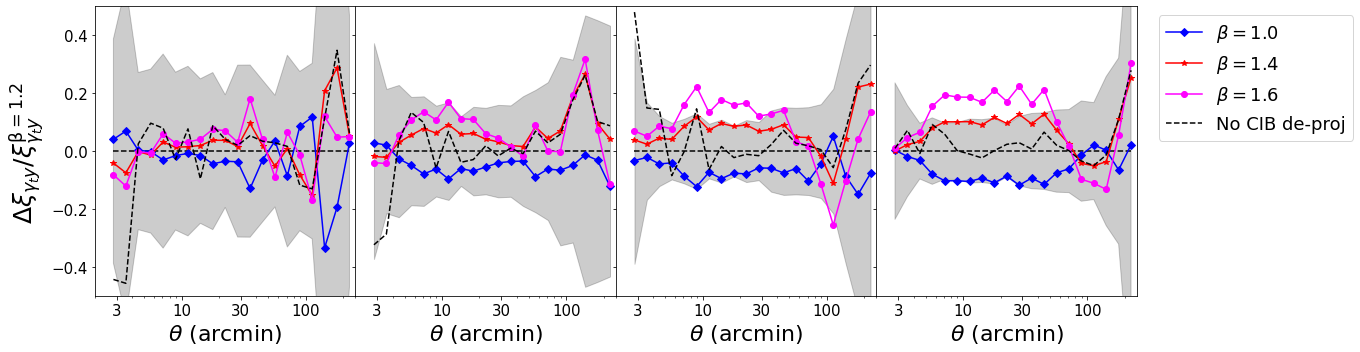

In [12]:
import scipy.interpolate as interpolate
def QR_inverse(matrix):
    _Q,_R = np.linalg.qr(matrix)
    return np.dot(_Q,np.linalg.inv(_R.T))
from astropy.io import fits
import pickle as pk
import numpy as np
import dill
import matplotlib
%matplotlib inline

# # df = fits.open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/actxdes_shear/DES_planck_ACT_theorycov.fits')

# df = fits.open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/actxdes_shear/DES_planck_ACT_theorycov.fits')   


# # desy1 = fits.open('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/data/v0.40_fiducial.fits')

nbins = 4
bins1 = np.array([1,2,3,4])
# bins2 = np.array([4,4,4,4])
bins2 = np.array([1,2,3,4])

# bins2 = np.array([2,2,2,2])
fig, ax = pl.subplots(1,4, figsize = (19,5),sharex=True,sharey='row', gridspec_kw = {'wspace':0})   
jc = 0
# texts_kk = [r'1,1',r'2,2',r'3,3',r'4,4']
texts_kk = []
for j1 in range(len(bins1)):
    texts_kk.append(str(bins1[j1]) + ',' + str(bins2[j1]))
texts_ky = [r'1,y',r'2,y',r'3,y',r'4,y']
sc1 = [20,7.1,1.1,1.1]
sc = [20,10.,7.1,7.1]
# ldir = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/run_measurements/results_ACT_DR6_DES_Y3/'
ldir = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/run_measurements/results_ACT_DR6_DES_Y3_18Oct22_newmask/'
# deproj_all = [ 'cib','cib_1p0','cib_1p4','cib_1p6', 'cib_1p8', 'cib_2p0']
# beta_vals = [r'$\beta = 1.2$', r'$\beta = 1.0$', r'$\beta = 1.4$', r'$\beta = 1.6$', r'$\beta = 1.8$', r'$\beta = 2.0$']

deproj_all = [ 'cib','cib_1p0','cib_1p4','cib_1p6', 'None']
beta_vals = [r'$\beta = 1.2$', r'$\beta = 1.0$', r'$\beta = 1.4$', r'$\beta = 1.6$', r'No CIB de-proj']

# colors = ['k','b','r','magenta','green','orange']
colors = ['k','b','r','magenta','black','orange']
ls_all = ['-','-','-','-','--','--']
markers_all = ['s','D','*','o','','']
for j2 in range(4):
    for j1 in range(len(deproj_all)):        
        df = dill.load(open(ldir + 'kg_act_deprojects_' + deproj_all[j1] + '_vnew_wbeam_pixell_zbin_' + str(j2) + '_njk_250_healpix4096_theta_2p5_250_v21May22.pk','rb'))
                
#         bin1y = df['compton_shear'].data['BIN1']
#         bin2y = df['compton_shear'].data['BIN2']
#         ind_sely = np.where((bin1y == bins1[j2]) & (bin2y == bins2[j2]))[0]

#         bin1y = df['compton1_shear'].data['BIN1']
#         bin2y = df['compton1_shear'].data['BIN2']
#         ind_sely1 = np.where((bin1y == bins1[j2]) & (bin2y == bins2[j2]))[0]

        rkg = df['r_kg']
        covkg = df['cov_dy']
        xikg = df['xi_kg']
        sigkg = np.sqrt(np.diag(covkg))
#         yk_th_g = df['compton_shear'].data['ANG'][ind_sely]
#         yk_val = df['compton_shear'].data['VALUE'][ind_sely]
#         yk_err = np.sqrt(np.diag(df['COVMAT'].data[400:480,400:480][ind_sely,:][:,ind_sely]))            

#         yk_th_g1 = df['compton1_shear'].data['ANG'][ind_sely1]
#         yk_val1 = df['compton1_shear'].data['VALUE'][ind_sely1]
#         yk_err1 = np.sqrt(np.diag(df['COVMAT'].data[480:,480:][ind_sely1,:][:,ind_sely1]))            
        if j1 == 0:
            xi_fid = xikg
            sig_fid = sigkg
            ax[j2].errorbar(rkg,-1+xikg/xi_fid, ls='--',marker='',color='k')
            ax[j2].fill_between(rkg,-1.*sigkg/xi_fid,sigkg/xi_fid, color='k', alpha=0.2)
        else:
            # ax[j2].errorbar(rkg,xikg, sigkg, ls='',marker='s',color=colors[j1])
            ax[j2].errorbar(rkg,-1 + xikg/xi_fid, ls=ls_all[j1],marker=markers_all[j1],color=colors[j1], label=beta_vals[j1])
        # ax[0,j2].errorbar(1.07*yk_th_g1, yk_val1,yk_err1, ls='',marker='o',color='red',label=r'ACT $\times$ DES')
        # ax[0,j2].axvspan(0,sc[j2],alpha=0.15,color='b')
        # ax[j2].axvspan(0,sc1[j2],alpha=0.05,color='b')
        
        # ind_sel = np.where(yk_th_g > sc[j2])[0]
        # ax[1,j2].errorbar(rkg[ind_sel],(xikg/sigkg)[ind_sel], ls='',marker='s',color='blue',label=r'Planck $\times$ DES')
        # ind_sel = np.where(rkg > sc1[j2])[0]
        # ax[1,j2].errorbar(rkg[ind_sel],(xikg/sigkg)[ind_sel], ls='',marker='o',color=colors[j1])  
        
        
        ax[j2].set_xscale('log')
        # ax[j2].set_yscale('log')
        
        ax[j2].set_xlabel(r'$\theta$ (arcmin)', size = 22)
        ticks  = np.array([3,10,30,100])
        labels_bottom = ticks
        ax[j2].set_xticks(ticks)
        ax[j2].set_xticks(ticks)
        ax[j2].set_xticklabels(labels_bottom,  fontsize=15)
            
        ax[j2].tick_params(axis='both', which='minor', labelsize=15)    
        ax[j2].tick_params(axis='both', which='major', labelsize=15)
        # ax[1,j2].tick_params(axis='both', which='minor', labelsize=15)    
        # ax[1,j2].tick_params(axis='both', which='major', labelsize=15)
        
        ax[j2].set_xlim((2,250))
        ax[j2].set_ylim(-0.5, 0.5)
        # ax[1,j2].set_ylim((0,13))
        
        # ax[0,j2].text( 0.85, 0.96,texts_ky[j2], verticalalignment='top', horizontalalignment='left', transform=ax[0,j2].transAxes, fontsize=15, bbox=dict(facecolor='white', edgecolor='black'))    
        # ax[1,j2].text( 0.85, 0.96,texts_ky[j2], verticalalignment='top', horizontalalignment='left', transform=ax[1,j2].transAxes, fontsize=15, bbox=dict(facecolor='white', edgecolor='black'))    


        jc += 1



# ax[0,0].set_ylabel(r'$\xi_{\rm mm}$ comparison', size = 22)
ax[0].set_ylabel(r'$\Delta \xi_{\gamma_t y}/ \xi^{\rm \beta=1.2}_{\gamma_t y}$ ', size = 25)
# ax[1,0].set_ylabel(r'SNR', size = 25)
# ax[1,0].set_ylabel(r'$\xi_{y\kappa}(\theta)$ ', size = 22)
# ax[1,0].set_ylabel(r'$\sigma(\xi_{+},\xi_{+})$ ', size = 22)
# ax[2,0].set_ylabel(r'$\sigma(\xi_{-},\xi_{-})$ ', size = 22)
# ax[1,0].legend(fontsize=15,loc='upper left',frameon=False)
ax[-1].legend(fontsize=18,loc='upper left', bbox_to_anchor=(1.05, 1.0))
#     ax[1,j].tick_params(axis='both', which='major', labelsize=15)

pl.tight_layout()




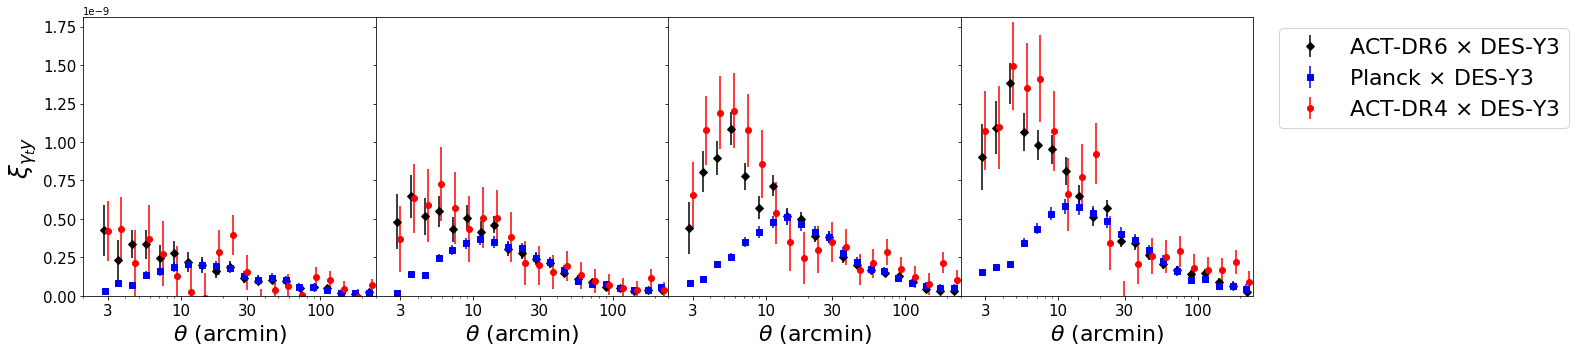

In [13]:
import scipy.interpolate as interpolate
def QR_inverse(matrix):
    _Q,_R = np.linalg.qr(matrix)
    return np.dot(_Q,np.linalg.inv(_R.T))
from astropy.io import fits
import pickle as pk
import numpy as np
import dill
import matplotlib
%matplotlib inline

# # df = fits.open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/actxdes_shear/DES_planck_ACT_theorycov.fits')

# df = fits.open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/actxdes_shear/DES_planck_ACT_theorycov.fits')   


# # desy1 = fits.open('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/data/v0.40_fiducial.fits')

nbins = 4
bins1 = np.array([1,2,3,4])
# bins2 = np.array([4,4,4,4])
bins2 = np.array([1,2,3,4])

# bins2 = np.array([2,2,2,2])
fig, ax = pl.subplots(1,4, figsize = (22,5),sharex=True,sharey='row', gridspec_kw = {'wspace':0})   
jc = 0
# texts_kk = [r'1,1',r'2,2',r'3,3',r'4,4']
texts_kk = []
for j1 in range(len(bins1)):
    texts_kk.append(str(bins1[j1]) + ',' + str(bins2[j1]))
texts_ky = [r'1,y',r'2,y',r'3,y',r'4,y']
sc1 = [20,7.1,1.1,1.1]
sc = [20,10.,7.1,7.1]
# ldir = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/run_measurements/results_ACT_DR6_DES_Y3/'
ldir = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/run_measurements/results_ACT_DR6_DES_Y3_18Oct22_newmask/'

deproj_all = [ 'cib']
beta_vals = [r'$\beta = 1.2$', r'$\beta = 1.0$', r'$\beta = 1.4$', r'$\beta = 1.6$', r'$\beta = 1.8$', r'$\beta = 2.0$']
colors = ['k','b','r','magenta','green','orange']






for j2 in range(4):
    for j1 in range(len(deproj_all)):        
        df = dill.load(open(ldir + 'kg_act_deprojects_' + deproj_all[j1] + '_vnew_wbeam_pixell_zbin_' + str(j2) + '_njk_250_healpix4096_theta_2p5_250_v21May22.pk','rb'))
        rkg = df['r_kg']
        covkg = df['cov_dy']
        xikg = df['xi_kg']
        sigkg = np.sqrt(np.diag(covkg))
        xi_fid = xikg
        sig_fid = sigkg
        ax[j2].errorbar(rkg,xikg, sigkg, ls='',marker='D',color='black',label=r'ACT-DR6 $\times$ DES-Y3')
        
        # if j1 == 0:
        #     xi_fid = xikg
        #     sig_fid = sigkg
        #     ax[j2].errorbar(rkg,xikg, sigkg, ls='--',marker='',color='k')
        #     # ax[j2].fill_between(rkg,-1.*sigkg/xi_fid,sigkg/xi_fid, color='k', alpha=0.2)
        # else:
        #     # ax[j2].errorbar(rkg,xikg, sigkg, ls='',marker='s',color=colors[j1])
        #     ax[j2].errorbar(rkg,-1 + xikg/xi_fid, ls='-',marker='s',color=colors[j1], label=beta_vals[j1])

        df = fits.open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/actxdes_shear/DES_planck_cib12_rm857_ACT_theorycov.fits')   
        bin1y = df['compton_shear'].data['BIN1']
        bin2y = df['compton_shear'].data['BIN2']
        ind_sely = np.where((bin1y == bins1[j2]) & (bin2y == bins2[j2]))[0]

        bin1y = df['compton1_shear'].data['BIN1']
        bin2y = df['compton1_shear'].data['BIN2']
        ind_sely1 = np.where((bin1y == bins1[j2]) & (bin2y == bins2[j2]))[0]

           
        yk_th_g = df['compton_shear'].data['ANG'][ind_sely]
        yk_val = df['compton_shear'].data['VALUE'][ind_sely]
        yk_err = np.sqrt(np.diag(df['COVMAT'].data[400:480,400:480][ind_sely,:][:,ind_sely]))            

        yk_th_g1 = df['compton1_shear'].data['ANG'][ind_sely1]
        yk_val1 = df['compton1_shear'].data['VALUE'][ind_sely1]
        yk_err1 = np.sqrt(np.diag(df['COVMAT'].data[480:,480:][ind_sely1,:][:,ind_sely1]))            
                
        ax[j2].errorbar(yk_th_g,yk_val, yk_err, ls='',marker='s',color='blue',label=r'Planck $\times$ DES-Y3')
        ax[j2].errorbar(1.05*yk_th_g1, yk_val1,yk_err1, ls='',marker='o',color='red',label=r'ACT-DR4 $\times$ DES-Y3')

        
        ax[j2].set_xscale('log')
        # ax[j2].set_yscale('log')
        
        
        ax[j2].set_xlabel(r'$\theta$ (arcmin)', size = 22)
        ticks  = np.array([3,10,30,100])
        labels_bottom = ticks
        ax[j2].set_xticks(ticks)
        ax[j2].set_xticks(ticks)
        ax[j2].set_xticklabels(labels_bottom,  fontsize=15)
            
        ax[j2].tick_params(axis='both', which='minor', labelsize=15)    
        ax[j2].tick_params(axis='both', which='major', labelsize=15)
        # ax[1,j2].tick_params(axis='both', which='minor', labelsize=15)    
        # ax[1,j2].tick_params(axis='both', which='major', labelsize=15)
        
        ax[j2].set_xlim((2,250))
        ax[j2].set_ylim((0.0e-9,1.81e-9))
        # ax[j2].set_ylim(-0.5, 0.5)
        # ax[1,j2].set_ylim((0,13))
        
        # ax[0,j2].text( 0.85, 0.96,texts_ky[j2], verticalalignment='top', horizontalalignment='left', transform=ax[0,j2].transAxes, fontsize=15, bbox=dict(facecolor='white', edgecolor='black'))    
        # ax[1,j2].text( 0.85, 0.96,texts_ky[j2], verticalalignment='top', horizontalalignment='left', transform=ax[1,j2].transAxes, fontsize=15, bbox=dict(facecolor='white', edgecolor='black'))    


        jc += 1



# ax[0,0].set_ylabel(r'$\xi_{\rm mm}$ comparison', size = 22)
# ax[0].set_ylabel(r'$\Delta \xi_{\gamma_t y}/ \xi^{\rm \beta=1.2}_{\gamma_t y}$ ', size = 25)
ax[0].set_ylabel(r'$\xi_{\gamma_t y}$ ', size = 25)
# ax[1,0].set_ylabel(r'SNR', size = 25)
# ax[1,0].set_ylabel(r'$\xi_{y\kappa}(\theta)$ ', size = 22)
# ax[1,0].set_ylabel(r'$\sigma(\xi_{+},\xi_{+})$ ', size = 22)
# ax[2,0].set_ylabel(r'$\sigma(\xi_{-},\xi_{-})$ ', size = 22)
# ax[1,0].legend(fontsize=15,loc='upper left',frameon=False)
ax[-1].legend(fontsize=22,loc='upper left', bbox_to_anchor=(1.05, 1.0))
#     ax[1,j].tick_params(axis='both', which='major', labelsize=15)

pl.tight_layout()
# pl.savefig('correlation_new_data.pdf')




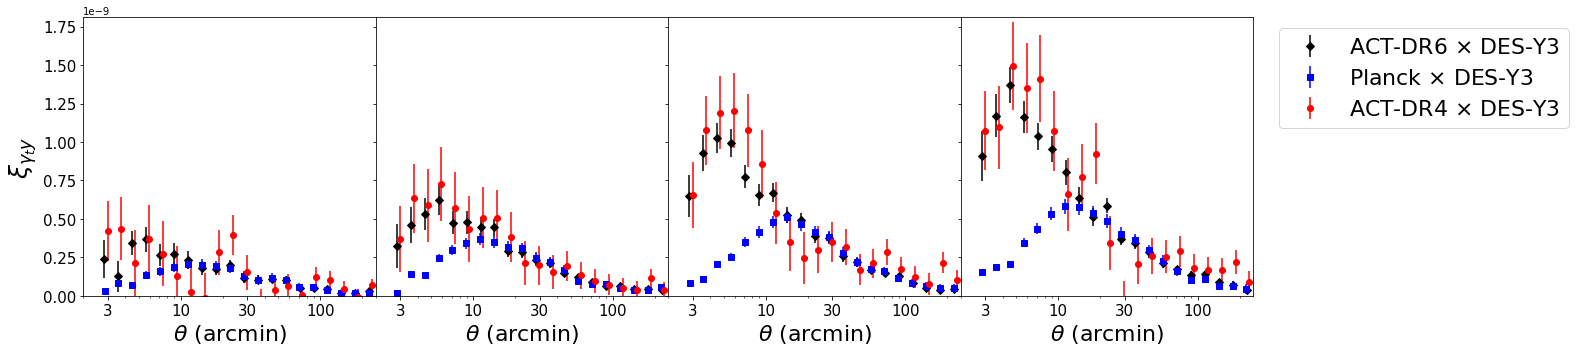

In [15]:
import scipy.interpolate as interpolate
def QR_inverse(matrix):
    _Q,_R = np.linalg.qr(matrix)
    return np.dot(_Q,np.linalg.inv(_R.T))
from astropy.io import fits
import pickle as pk
import numpy as np
import dill
import matplotlib
%matplotlib inline

# # df = fits.open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/actxdes_shear/DES_planck_ACT_theorycov.fits')

# df = fits.open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/actxdes_shear/DES_planck_ACT_theorycov.fits')   


# # desy1 = fits.open('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/data/v0.40_fiducial.fits')

nbins = 4
bins1 = np.array([1,2,3,4])
# bins2 = np.array([4,4,4,4])
bins2 = np.array([1,2,3,4])

# bins2 = np.array([2,2,2,2])
fig, ax = pl.subplots(1,4, figsize = (22,5),sharex=True,sharey='row', gridspec_kw = {'wspace':0})   
jc = 0
# texts_kk = [r'1,1',r'2,2',r'3,3',r'4,4']
texts_kk = []
for j1 in range(len(bins1)):
    texts_kk.append(str(bins1[j1]) + ',' + str(bins2[j1]))
texts_ky = [r'1,y',r'2,y',r'3,y',r'4,y']
sc1 = [20,7.1,1.1,1.1]
sc = [20,10.,7.1,7.1]
# ldir = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/run_measurements/results_ACT_DR6_DES_Y3/'
ldir = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/run_measurements/results_ACT_DR6_DES_Y3_18Oct22_newmask/'

deproj_all = [ 'None']
beta_vals = [r'$\beta = 1.2$', r'$\beta = 1.0$', r'$\beta = 1.4$', r'$\beta = 1.6$', r'$\beta = 1.8$', r'$\beta = 2.0$']
colors = ['k','b','r','magenta','green','orange']






for j2 in range(4):
    for j1 in range(len(deproj_all)):        
        df = dill.load(open(ldir + 'kg_act_deprojects_' + deproj_all[j1] + '_vnew_wbeam_pixell_zbin_' + str(j2) + '_njk_250_healpix4096_theta_2p5_250_v21May22.pk','rb'))
        rkg = df['r_kg']
        covkg = df['cov_dy']
        xikg = df['xi_kg']
        sigkg = np.sqrt(np.diag(covkg))
        xi_fid = xikg
        sig_fid = sigkg
        ax[j2].errorbar(rkg,xikg, sigkg, ls='',marker='D',color='black',label=r'ACT-DR6 $\times$ DES-Y3')
        
        # if j1 == 0:
        #     xi_fid = xikg
        #     sig_fid = sigkg
        #     ax[j2].errorbar(rkg,xikg, sigkg, ls='--',marker='',color='k')
        #     # ax[j2].fill_between(rkg,-1.*sigkg/xi_fid,sigkg/xi_fid, color='k', alpha=0.2)
        # else:
        #     # ax[j2].errorbar(rkg,xikg, sigkg, ls='',marker='s',color=colors[j1])
        #     ax[j2].errorbar(rkg,-1 + xikg/xi_fid, ls='-',marker='s',color=colors[j1], label=beta_vals[j1])

        df = fits.open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/actxdes_shear/DES_planck_cib12_rm857_ACT_theorycov.fits')   
        bin1y = df['compton_shear'].data['BIN1']
        bin2y = df['compton_shear'].data['BIN2']
        ind_sely = np.where((bin1y == bins1[j2]) & (bin2y == bins2[j2]))[0]

        bin1y = df['compton1_shear'].data['BIN1']
        bin2y = df['compton1_shear'].data['BIN2']
        ind_sely1 = np.where((bin1y == bins1[j2]) & (bin2y == bins2[j2]))[0]

           
        yk_th_g = df['compton_shear'].data['ANG'][ind_sely]
        yk_val = df['compton_shear'].data['VALUE'][ind_sely]
        yk_err = np.sqrt(np.diag(df['COVMAT'].data[400:480,400:480][ind_sely,:][:,ind_sely]))            

        yk_th_g1 = df['compton1_shear'].data['ANG'][ind_sely1]
        yk_val1 = df['compton1_shear'].data['VALUE'][ind_sely1]
        yk_err1 = np.sqrt(np.diag(df['COVMAT'].data[480:,480:][ind_sely1,:][:,ind_sely1]))            
                
        ax[j2].errorbar(yk_th_g,yk_val, yk_err, ls='',marker='s',color='blue',label=r'Planck $\times$ DES-Y3')
        ax[j2].errorbar(1.05*yk_th_g1, yk_val1,yk_err1, ls='',marker='o',color='red',label=r'ACT-DR4 $\times$ DES-Y3')

        
        ax[j2].set_xscale('log')
        # ax[j2].set_yscale('log')
        
        
        ax[j2].set_xlabel(r'$\theta$ (arcmin)', size = 22)
        ticks  = np.array([3,10,30,100])
        labels_bottom = ticks
        ax[j2].set_xticks(ticks)
        ax[j2].set_xticks(ticks)
        ax[j2].set_xticklabels(labels_bottom,  fontsize=15)
            
        ax[j2].tick_params(axis='both', which='minor', labelsize=15)    
        ax[j2].tick_params(axis='both', which='major', labelsize=15)
        # ax[1,j2].tick_params(axis='both', which='minor', labelsize=15)    
        # ax[1,j2].tick_params(axis='both', which='major', labelsize=15)
        
        ax[j2].set_xlim((2,250))
        ax[j2].set_ylim((0.0e-9,1.81e-9))
        # ax[j2].set_ylim(-0.5, 0.5)
        # ax[1,j2].set_ylim((0,13))
        
        # ax[0,j2].text( 0.85, 0.96,texts_ky[j2], verticalalignment='top', horizontalalignment='left', transform=ax[0,j2].transAxes, fontsize=15, bbox=dict(facecolor='white', edgecolor='black'))    
        # ax[1,j2].text( 0.85, 0.96,texts_ky[j2], verticalalignment='top', horizontalalignment='left', transform=ax[1,j2].transAxes, fontsize=15, bbox=dict(facecolor='white', edgecolor='black'))    


        jc += 1



# ax[0,0].set_ylabel(r'$\xi_{\rm mm}$ comparison', size = 22)
# ax[0].set_ylabel(r'$\Delta \xi_{\gamma_t y}/ \xi^{\rm \beta=1.2}_{\gamma_t y}$ ', size = 25)
ax[0].set_ylabel(r'$\xi_{\gamma_t y}$ ', size = 25)
# ax[1,0].set_ylabel(r'SNR', size = 25)
# ax[1,0].set_ylabel(r'$\xi_{y\kappa}(\theta)$ ', size = 22)
# ax[1,0].set_ylabel(r'$\sigma(\xi_{+},\xi_{+})$ ', size = 22)
# ax[2,0].set_ylabel(r'$\sigma(\xi_{-},\xi_{-})$ ', size = 22)
# ax[1,0].legend(fontsize=15,loc='upper left',frameon=False)
ax[-1].legend(fontsize=22,loc='upper left', bbox_to_anchor=(1.05, 1.0))
#     ax[1,j].tick_params(axis='both', which='major', labelsize=15)

pl.tight_layout()
# pl.savefig('correlation_new_data.pdf')



